In [2]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

print(tf.__version__)

2.1.0


In [4]:
# 正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本，小圆环分布
# 圆的半径+随机值
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
# 圆的角度
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi)
# 计算圆点的位置，利用tf.concat实现数据的拼接
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis=1)
# 标签为1，正样本标签的数据
Yp = tf.ones_like(r_p)

#生成负样本，小圆环分布
# 圆的半径+随机值
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
# 圆的角度
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi)
# 计算圆点的位置，tf.concat将数据在列维度上拼接
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis=1)
# 标签为0，负样本标签的数据
Yn = tf.zeros_like(r_n)

# 汇总数据
X = tf.concat([Xp,Xn],axis=0)
Y = tf.concat([Yp,Yn],axis=0)

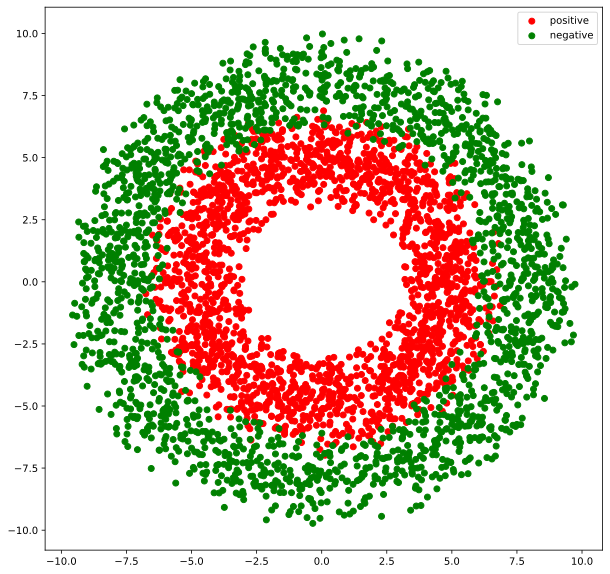

In [5]:
#可视化
plt.figure(figsize = (10,10))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"])

In [13]:
# 构建管道数据
n=4000
# 生成训练的数据集
ds_train = tf.data.Dataset.from_tensor_slices((X[0:3000,:],Y[0:3000,:]))\
        .shuffle(buffer_size=3000).batch(10)\
        .prefetch(tf.data.experimental.AUTOTUNE)\
        .cache()

# 生成验证的数据集
ds_valid = tf.data.Dataset.from_tensor_slices((X[n*3//4:,:],Y[n*3//4:,:])) \
     .batch(20) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()


In [16]:
# 定义模型

tf.keras.backend.clear_session()

# 这里使用利用kears models.Model来构建的
class DNNModel(tf.keras.models.Model):
    def __init__(self):
        super(DNNModel,self).__init__()

    # 搭建模型框架
    def build(self,input_shape):
        self.dense1 = layers.Dense(4,activation="relu",name="dense1")
        self.dense2 = layers.Dense(8,activation="relu",name="dense2")
        self.dense3 = layers.Dense(1,activation="sigmoid",name="dense3")
        super(DNNModel,self).build(input_shape)

    #构建模型实现正向传播
    @tf.function(input_signature =[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def call(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y


model = DNNModel()
model.build(input_shape=(None,2))

model.summary()
    

Model: "dnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               multiple                  12        
_________________________________________________________________
dense2 (Dense)               multiple                  40        
_________________________________________________________________
dense3 (Dense)               multiple                  9         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 训练模型

optimizer = optimizers.Adam(learning_rate=0.01)
loss_func = tf.keras.losses.BinaryCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_metric = tf.keras.metrics.BinaryAccuracy(name="train_metric")

valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_metric = tf.keras.metrics.BinaryAccuracy(name="valid_metric")

In [18]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_func(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)

@tf.function
def valid_step(model, features, labels):
    predictions = model(features)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)
    

def train_model(model,ds_train,ds_valid,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in ds_train:
            train_step(model,features,labels)

        for features, labels in ds_valid:
            valid_step(model,features,labels)

        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'
        
        if  epoch%100 ==0:
            printbar()
            tf.print(tf.strings.format(logs,
            (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))
        
        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()

train_model(model,ds_train,ds_valid,1000)

================================================================================08:46:20
Epoch=100,Loss:0.111681134,Accuracy:0.95,Valid Loss:0.231950462,Valid Accuracy:0.894
================================================================================08:46:50
Epoch=200,Loss:0.105597,Accuracy:0.952,Valid Loss:0.216598913,Valid Accuracy:0.899
================================================================================08:47:15
Epoch=300,Loss:0.104721591,Accuracy:0.952333331,Valid Loss:0.215905279,Valid Accuracy:0.898
================================================================================08:47:40
Epoch=400,Loss:0.104013406,Accuracy:0.954333305,Valid Loss:0.227550849,Valid Accuracy:0.898
================================================================================08:48:06
Epoch=500,Loss:0.103665568,Accuracy:0.95266664,Valid Loss:0.218576312,Valid Accuracy:0.898
================================================================================08:48:31
Epoch=600,Loss:0.103024

In [ ]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"])
ax1.set_title("y_true")

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"])
ax2.set_title("y_pred")